# Time Series Forecasting with Python Final Project

## Importing Required Modules

In [1]:
# Import necessary libraries
import pandas as pd
import json
from os import path
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
from sktime.forecasting.ltsf import LTSFLinearForecaster,LTSFDLinearForecaster,LTSFNLinearForecaster
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from prophet import Prophet

# Dictionary to store the best hyperparameter configurations for different models
best_tree_states = {
    "xgboost" : {},
    "random_forest" : {},
    "prophet" : {}
}

Importing plotly failed. Interactive plots will not work.


## Utility Functions

In [2]:
# Function to split time series data into training and testing sets
def ts_split(train_df, test_pct=0.2, random_state=25, freq='D'):
    """
    Splits the time series data into training and testing sets.

    Parameters:
    - train_df (pd.DataFrame): Time series data.
    - test_pct (float): Percentage of data to be used for testing.
    - random_state (int): Random seed for reproducibility.
    - freq (str): Frequency of the time series data.

    Returns:
    - train_data (pd.DataFrame): Training data.
    - test_data (pd.DataFrame): Testing data.
    """
    from sklearn.model_selection import train_test_split

    train_df = train_df.groupby(pd.Grouper(freq=freq)).mean(numeric_only=True)
    test_size = int(len(train_df) * test_pct)
    train_data, test_data = train_test_split(train_df, test_size=test_size, random_state=random_state, shuffle=False)
    return train_data, test_data


# Function to calculate various error metrics
def errors(truth=np.array([[1, 1]]), pred=np.array([[1, 1]])):
    """
    Calculates and returns various error metrics for forecasting models.

    Parameters:
    - truth (numpy.ndarray): Actual values.
    - pred (numpy.ndarray): Predicted values.

    Returns:
    - error_str (str): Formatted string containing error metrics.
    """
    from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

    error_str = "\n\
    Mean Squared Error: {:0.3f}\n\
    Mean Absolute Error: {:0.3f}\n\
    Mean Absolute Percentage Error: {:0.3f}\n\
    Weighted Mean Squared Error: {:0.3f}\n\
    Mean Forecast Error: {:0.3f}\n\
    ".format(mean_squared_error(truth, pred) ** 0.5,
              mean_absolute_error(truth, pred),
              mean_absolute_percentage_error(truth, pred),
              mean_squared_error(truth, pred, sample_weight=np.exp(-np.arange(len(truth)))) ** 0.5,
              np.mean(truth - pred))
    return error_str


# Function to calculate a specific error metric
def get_error(truth, pred):
    """
    Calculates and returns the root mean squared error.

    Parameters:
    - truth (numpy.ndarray): Actual values.
    - pred (numpy.ndarray): Predicted values.

    Returns:
    - float: Root Mean Squared Error.
    """
    from sklearn.metrics import mean_squared_error
    return mean_squared_error(truth, pred) ** 0.5


# Function to check if the current error is lower than the minimum error
def check_error(cur_error, min_error):
    """
    Checks if the current error is lower than the minimum error.

    Parameters:
    - cur_error (float): Current error value.
    - min_error (float): Minimum error value.

    Returns:
    - bool: True if the current error is lower, False otherwise.
    """
    return cur_error < min_error


# Function to plot ACF and PACF and return the maximum lag with significant correlation
def acf_pacf(data, conf_thresh=0.2, make_plot=False, nlags=20):
    """
    Plots the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
    and returns the maximum lag with significant correlation.

    Parameters:
    - data (pd.Series): Time series data.
    - conf_thresh (float): Threshold for significant correlation.
    - make_plot (bool): Whether to create plots.
    - nlags (int): Number of lags to consider.

    Returns:
    - int: Maximum lag with significant correlation.
    """
    import matplotlib.pyplot as plt
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.tsa.stattools import acf, pacf

    if make_plot:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        plot_acf(data, lags=nlags, ax=axes[0])
        plot_pacf(data, lags=nlags, ax=axes[1])
        plt.show()

    acf_vals = acf(data, nlags=nlags)
    pacf_vals = pacf(data, nlags=nlags)
    max_acf_lag = max(np.where(np.abs(acf_vals) > conf_thresh)[0])
    max_pacf_lag = max(np.where(np.abs(pacf_vals) > conf_thresh)[0])

    return max([max_acf_lag, max_pacf_lag])


# Function to create lagged columns for time series data
def create_lagged_columns(series, num_lags):
    """
    Creates lagged columns for a time series.

    Parameters:
    - series (pd.Series): Time series data.
    - num_lags (int): Number of lags to create.

    Returns:
    - pd.DataFrame: DataFrame with lagged columns.
    """
    lagged_df = pd.DataFrame({'lag_0': series})

    for i in range(1, num_lags + 1):
        lagged_df[f'lag_{i}'] = series.shift(i)
    lagged_df.rename(columns={"lag_0": "label"}, inplace=True)
    lagged_df = lagged_df.fillna(method="bfill")
    return lagged_df


# Function to calculate savings based on production, consumption, and electricity prices
def savings_calculation(production_final, consumption_final, electricity_prices_final):
    """
    Calculates and returns savings based on production, consumption, and electricity prices.

    Parameters:
    - production_final (pd.Series): Production data.
    - consumption_final (pd.Series): Consumption data.
    - electricity_prices_final (pd.Series): Electricity prices data.

    Returns:
    - float: Total savings.
    """
    savings = 0
    for amount, price in zip(list(production_final), list(electricity_prices_final)):
        savings += (amount / (10 ** 2)) * price
    return savings


# Function to create lagged columns for time series data
def ts_split(train_df, test_pct=0.2, random_state=25, freq='D'):
    """
    Splits the time series data into training and testing sets.

    Parameters:
    - train_df (pd.DataFrame): Time series data.
    - test_pct (float): Percentage of data to be used for testing.
    - random_state (int): Random seed for reproducibility.
    - freq (str): Frequency of the time series data.

    Returns:
    - train_data (pd.DataFrame): Training data.
    - test_data (pd.DataFrame): Testing data.
    """
    from sklearn.model_selection import train_test_split

    train_df = train_df.groupby(pd.Grouper(freq=freq)).mean(numeric_only=True)
    test_size = int(len(train_df) * test_pct)
    train_data, test_data = train_test_split(train_df, test_size=test_size, random_state=random_state, shuffle=False)
    return train_data, test_data


# Function to create a DataFrame with error metrics for multiple models
def error_table(error_dict):
    """
    Creates a DataFrame with error metrics for multiple models.

    Parameters:
    - error_dict (dict): Dictionary containing error metrics for each model.

    Returns:
    - pd.DataFrame: DataFrame with error metrics.
    """
    col_names = ["Mean Squared Error", "Mean Absolute Error", "Mean Absolute Percentage Error", "Mean Forecast Error"]
    data = list(error_dict.values())
    index_vals = error_dict.keys()
    df = pd.DataFrame(data=data, columns=col_names, index=index_vals)
    return df


# Function to compare different error metrics and return a list
def compare_errors(truth=np.array([[1, 1]]), pred=np.array([[1, 1]])):
    '''
    Calculates and returns a list of different error metrics for forecasting models.

    Parameters:
    - truth (numpy.ndarray): Actual values.
    - pred (numpy.ndarray): Predicted values.

    Returns:
    - error_list (list): List containing Root Mean Squared Error, Mean Absolute Error,
      Mean Absolute Percentage Error, and Mean Forecast Error.
    '''
    from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

    error_list = [
        mean_squared_error(truth, pred) ** 0.5,
        mean_absolute_error(truth, pred),
        mean_absolute_percentage_error(truth, pred),
        np.mean(truth - pred)
    ]

    return error_list


# Function to create a DataFrame with error metrics for multiple models
def error_table(error_dict):
    """
    Creates a DataFrame with error metrics for multiple models.

    Parameters:
    - error_dict (dict): Dictionary containing error metrics for each model.

    Returns:
    - pd.DataFrame: DataFrame with error metrics.
    """
    col_names = ["Mean Squared Error", "Mean Absolute Error", "Mean Absolute Percentage Error", "Mean Forecast Error"]
    data = list(error_dict.values())
    index_vals = error_dict.keys()
    df = pd.DataFrame(data=data, columns=col_names, index=index_vals)
    return df


## Functions to train models

In [3]:
# Function to fit and compare various ETS (Exponential Smoothing State space model) models
def ets_models(train_data, test_data, col_name, pts_to_pred):
    """
    Fits and compares various ETS models to find the best model based on minimum error.

    Parameters:
    - train_data (pd.DataFrame): Training data.
    - test_data (pd.DataFrame): Testing data.
    - col_name (str): Name of the column to forecast.
    - pts_to_pred (int): Number of points to forecast.

    Returns:
    - best_model: Best ETS model based on minimum error.
    """
    min_error = np.inf
    best_model = None
    granularity = 0.01

    # Simple Exponential Smoothing
    for level in np.arange(0, 1 + granularity, granularity):
        ses = SimpleExpSmoothing(train_data[col_name]).fit(smoothing_level=level, optimized=False)
        ses_forecast = ses.forecast(pts_to_pred)
        cur_error = get_error(test_data[col_name], ses_forecast.values)
        if check_error(cur_error, min_error):
            min_error = cur_error
            best_model = ses

    # Double and Triple Exponential Smoothing
    for trend_type in ["add", "mul"]:
        des = ExponentialSmoothing(train_data[col_name], trend=trend_type).fit()
        des_forecast = des.forecast(pts_to_pred)
        cur_error = get_error(test_data[col_name], des_forecast.values)
        if check_error(cur_error, min_error):
            min_error = cur_error
            best_model = des

    # Seasonal Exponential Smoothing
    for trend_type in ["add", "mul"]:
        for seasonality_type in ["add", "mul"]:
            for seasonality in range(2, 13):
                tes = ExponentialSmoothing(train_data[col_name], trend=trend_type, seasonal=seasonality_type,
                                           seasonal_periods=seasonality).fit()
                tes_forecast = tes.forecast(pts_to_pred)
                cur_error = get_error(test_data[col_name], tes_forecast.values)
                if check_error(cur_error, min_error):
                    min_error = cur_error
                    best_model = tes

    return best_model


# Function to fit and compare various ARIMA (AutoRegressive Integrated Moving Average) models
def arima_models(train_data, test_data, col_name, pts_to_pred):
    """
    Fits and compares various ARIMA models to find the best model based on minimum error.

    Parameters:
    - train_data (pd.DataFrame): Training data.
    - test_data (pd.DataFrame): Testing data.
    - col_name (str): Name of the column to forecast.
    - pts_to_pred (int): Number of points to forecast.

    Returns:
    - best_model: Best ARIMA model based on minimum error.
    """
    best_model = None
    min_error = np.inf

    # Iterate over different seasonal periods
    for seasonality in range(1, 13):
        model = pm.auto_arima(train_data[col_name],
                              test='adf',
                              max_p=2, max_q=2, m=seasonality,
                              seasonal=True,
                              trace=False,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)
        model_forecast = model.predict(n_periods=pts_to_pred, return_conf_int=False)
        cur_error = get_error(test_data[col_name], model_forecast)
        if check_error(cur_error, min_error):
            min_error = cur_error
            best_model = model

    return best_model


# Function to fit and compare various LTSF (Long-Term Short-Term Forecaster) models
def ltsf_models(train_data, test_data, col_name, pts_to_pred):
    """
    Fits and compares various LTSF models to find the best model based on minimum error.

    Parameters:
    - train_data (pd.DataFrame): Training data.
    - test_data (pd.DataFrame): Testing data.
    - col_name (str): Name of the column to forecast.
    - pts_to_pred (int): Number of points to forecast.

    Returns:
    - best_model: Best LTSF model based on minimum error.
    """
    best_model = None
    min_error = np.inf

    # Iterate over different LTSF models and hyperparameters
    for model in [LTSFLinearForecaster, LTSFDLinearForecaster, LTSFNLinearForecaster]:
        for ip_seq_len in [4, 52, 10, 8, 5]:
            for batch_size in [4, 8, 16, 32]:
                for epochs in range(10, 101, 10):
                    cur_model = model(ip_seq_len, len(test_data), num_epochs=epochs, batch_size=batch_size)
                    cur_model.fit(train_data[col_name], fh=list(range(len(test_data))))
                    model_forecast = cur_model.predict()
                    cur_error = get_error(test_data[col_name], model_forecast)
                    if check_error(cur_error, min_error):
                        min_error = cur_error
                        best_model = cur_model

    return best_model


# Function to fit and compare various Random Forest Regressor models
def randomforestregressors(train_data, test_data, col_name, pts_to_pred):
    """
    Fits and compares various Random Forest Regressor models to find the best model based on minimum error.

    Parameters:
    - train_data (pd.DataFrame): Training data.
    - test_data (pd.DataFrame): Testing data.
    - col_name (str): Name of the column to forecast.
    - pts_to_pred (int): Number of points to forecast.

    Returns:
    - best_model: Best Random Forest Regressor model based on minimum error.
    """
    max_lags = 10
    max_estimators = 200
    global best_tree_states
    min_error = np.inf
    best_model = None

    # Iterate over different numbers of estimators and lags
    for n_estimator in range(1, max_estimators, 5):
        for lag in range(1, max_lags):
            lagged_train_data = create_lagged_columns(train_data[col_name], num_lags=lag)
            train_X = lagged_train_data.drop(columns="label")
            train_y = lagged_train_data["label"]
            cur_model = RandomForestRegressor(n_estimators=n_estimator, random_state=42)
            cur_model.fit(train_X, train_y)

            lagged_test_data = create_lagged_columns(test_data[col_name], num_lags=lag)

            y_pred = cur_model.predict(lagged_test_data.drop(columns="label"))
            cur_error = get_error(lagged_test_data["label"], y_pred)
            if check_error(cur_error, min_error):
                min_error = cur_error
                best_model = cur_model
                best_tree_states["random_forest"]["nlags"] = lag
                best_tree_states["random_forest"]["nEstimator"] = n_estimator

    return best_model


# Function to fit and compare various XGBoost Regressor models
def xgboostregressors(train_data, test_data, col_name, pts_to_pred):
    """
    Fits and compares various XGBoost Regressor models to find the best model based on minimum error.

    Parameters:
    - train_data (pd.DataFrame): Training data.
    - test_data (pd.DataFrame): Testing data.
    - col_name (str): Name of the column to forecast.
    - pts_to_pred (int): Number of points to forecast.

    Returns:
    - best_model: Best XGBoost Regressor model based on minimum error.
    """
    global best_tree_states
    max_lags = 10
    min_error = np.inf
    best_model = None

    # Iterate over different numbers of lags
    for lag in range(1, max_lags):
        cur_model = XGBRegressor()

        lagged_train_data = create_lagged_columns(train_data[col_name], num_lags=lag)
        train_X = lagged_train_data.drop(columns="label")
        train_y = lagged_train_data["label"]

        lagged_test_data = create_lagged_columns(test_data[col_name], num_lags=lag)

        cur_model.fit(train_X, train_y)

        y_pred = cur_model.predict(lagged_test_data.drop(columns="label"))

        cur_error = get_error(lagged_test_data["label"], y_pred)
        if check_error(cur_error, min_error):
            min_error = cur_error
            best_model = cur_model
            best_tree_states["xgboost"]["nlags"] = lag

    return best_model


# Function to fit and compare various Facebook Prophet models
def fbprophet(train_data, test_data, col_name, pts_to_pred):
    """
    Fits and compares various Facebook Prophet models to find the best model based on minimum error.

    Parameters:
    - train_data (pd.DataFrame): Training data.
    - test_data (pd.DataFrame): Testing data.
    - col_name (str): Name of the column to forecast.
    - pts_to_pred (int): Number of points to forecast.

    Returns:
    - best_model: Best Facebook Prophet model based on minimum error.
    """
    global best_tree_states
    max_lags = 10
    min_error = np.inf
    best_model = None

    # Iterate over different numbers of lags
    for lag in range(1, max_lags):
        cur_model = Prophet(yearly_seasonality=True)

        lagged_train_data = create_lagged_columns(train_data[col_name], num_lags=lag)
        lagged_train_data["ds"] = lagged_train_data.index
        prophet_train_data = lagged_train_data.rename(columns={"label": "y"})

        cur_model.fit(prophet_train_data)

        lagged_test_data = create_lagged_columns(test_data[col_name], num_lags=lag)
        lagged_test_data["ds"] = lagged_test_data.index
        prophet_test_data = lagged_test_data.rename(columns={"label": "y"})

        future = cur_model.make_future_dataframe(periods=pts_to_pred, freq='W')

        # Generate forecasts
        y_pred = cur_model.predict(future)[-len(lagged_test_data.index):]
        cur_error = get_error(prophet_test_data["y"], y_pred["yhat"])
        if check_error(cur_error, min_error):
            min_error = cur_error
            best_model = cur_model
            best_tree_states["prophet"]["nlags"] = lag

    return best_model


# Function to plot the time series data before training the models
def pretraining_plot(train_df, test_df, col_name, title="Title"):
    """
    Plots the time series data before training the models.

    Parameters:
    - train_df (pd.DataFrame): Training data.
    - test_df (pd.DataFrame): Testing data.
    - col_name (str): Name of the column to plot.
    - title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 5))
    train_df[col_name].plot(label='Train')
    test_df[col_name].plot(label='Test')
    plt.title(title)
    plt.xlabel('Date')
    plt.legend()


# Function to plot the time series data after training the models
def posttraining_plot(train_df, test_df, col_name, best_model, title="Title"):
    """
    Plots the time series data after training the models, including the best model's forecast.

    Parameters:
    - train_df (pd.DataFrame): Training data.
    - test_df (pd.DataFrame): Testing data.
    - col_name (str): Name of the column to plot.
    - best_model: Best forecasting model.
    - title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 5))
    train_df[col_name].plot(label='Train', color="black")
    test_df[col_name].plot(label='Test', color="orange")
    best_forecast = best_model.forecast(len(test_df))
    print(errors(test_df[col_name], best_forecast))
    pd.Series(best_forecast, index=test_df.index).plot(label="Best Model Pred", color="blue")
    plt.title(title)
    plt.xlabel('Date')
    plt.legend()

## Wrapper to forecast with various models

In [4]:
class BestModelWrapper:
    def __init__(self, model):
        """
        Wrapper class for the best forecasting model.

        Parameters:
        - model: Best forecasting model.
        """
        self.best_model = model
        self.model_type = str(type(model))
        self._forecast_call = self._get_forecast_call()

    def forecast(self, pts_to_pred):
        """
        Generates forecasts using the best model.

        Parameters:
        - pts_to_pred (int): Number of points to forecast.

        Returns:
        - cur_forecast: Forecasted values.
        """
        global prediction_data
        global prediction_colname

        cur_forecast = None
        if self._forecast_call == 0:
            # ARIMA model
            cur_forecast = self.best_model.predict(n_periods=pts_to_pred, return_conf_int=False)
        elif self._forecast_call == 1:
            # LTSF model
            cur_forecast = self.best_model.predict()
        elif self._forecast_call == 3:
            # Random Forest Regressor
            lagged_test_data = create_lagged_columns(prediction_data[prediction_colname],
                                                     num_lags=best_tree_states["random_forest"]["nlags"])
            cur_forecast = self.best_model.predict(lagged_test_data.drop(columns="label"))

        elif self._forecast_call == 4:
            # XGBoost Regressor
            lagged_test_data = create_lagged_columns(prediction_data[prediction_colname],
                                                     num_lags=best_tree_states["xgboost"]["nlags"])
            cur_forecast = self.best_model.predict(lagged_test_data.drop(columns="label"))

        elif self._forecast_call == 5:
            # Facebook Prophet
            future = self.best_model.make_future_dataframe(periods=pts_to_pred, freq='W')
            cur_forecast = self.best_model.predict(future)[-pts_to_pred:]["yhat"].values

        else:
            # ETS model
            cur_forecast = self.best_model.forecast(pts_to_pred).values
        return cur_forecast

    def _get_forecast_call(self):
        """
        Determines the type of forecasting model and returns the corresponding code.

        Returns:
        - forecast_call (int): Code representing the type of forecasting model.
        """
        if self.model_type == "<class 'pmdarima.arima.arima.ARIMA'>":
            self.model_type = "ARIMA"
            return 0
        elif self.model_type in ["<class 'sktime.forecasting.ltsf.LTSFDLinearForecaster'>",
                                 "<class 'sktime.forecasting.ltsf.LTSFLinearForecaster'>",
                                 "<class 'sktime.forecasting.ltsf.LTSFNLinearForecaster'>"]:
            self.model_type = "LTSFLinearForecaster"
            return 1
        elif self.model_type == "<class 'sklearn.ensemble._forest.RandomForestRegressor'>":
            self.model_type = "Random Forest Regressor"
            return 3
        elif self.model_type == "<class 'xgboost.sklearn.XGBRegressor'>":
            self.model_type = "XG Boost Regressor"
            return 4
        elif self.model_type == "<class 'prophet.forecaster.Prophet'>":
            self.model_type = "FB Prophet"
            return 5
        else:
            self.model_type = "ETS"
            return 2


# Loading Data and EDA

In [5]:
trainf_path = "data/project/predict-energy-behavior-of-prosumers" # - Directory with train csv files.  
testf_path = "data/project/predict-energy-behavior-of-prosumers/test_files" # - Directory with test csv files.

electricity_prices_csv = "electricity_prices.csv"
train_csv = "train.csv"

In [6]:
electricity_prices_df = pd.read_csv(path.join(trainf_path,electricity_prices_csv))
electricity_prices_df.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [7]:
train_df = pd.read_csv(path.join(trainf_path,train_csv))
train_df["county"].value_counts()

0     212928
11    198000
7     173088
5     151632
15    148752
4     147264
10    134640
14    125808
3     122496
9     122496
13    121056
2     115200
1      91872
8      91872
6      30624
12     30624
Name: county, dtype: int64

## Selecting County

In [8]:
print(train_df.county.unique())
select_county = 5

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


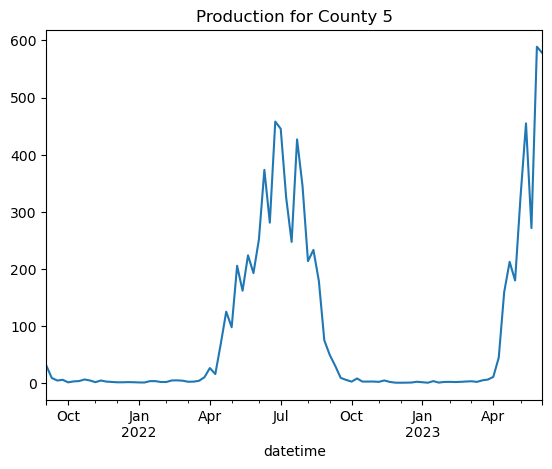

In [9]:
temp = train_df.copy()
temp = temp[temp["is_consumption"] == 0]
temp.set_index("datetime",inplace=True)
filtered_temp = temp.groupby(by = [temp.index,"county"]).sum()
filtered_temp.reset_index(inplace=True)
filtered_temp = filtered_temp[filtered_temp["county"] == select_county]
filtered_temp["datetime"] = pd.to_datetime(filtered_temp["datetime"])
filtered_temp.set_index("datetime",inplace=True)
filtered_temp = filtered_temp.groupby(pd.Grouper(freq='W')).median()
filtered_temp["target"].plot()
plt.title("Production for County {}".format(select_county))
plt.show()

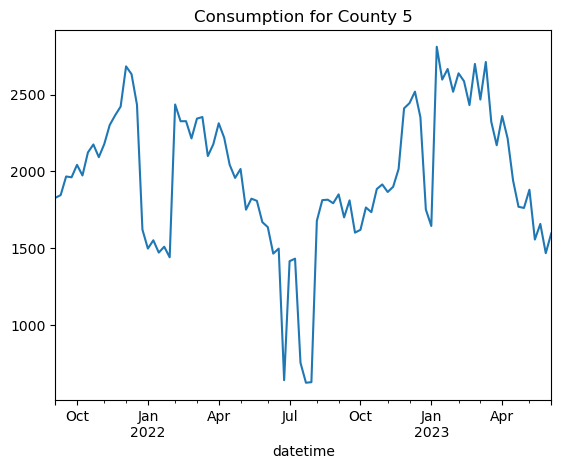

In [10]:
temp = train_df.copy()
temp = temp[temp["is_consumption"] == 1]
temp.set_index("datetime",inplace=True)
filtered_temp = temp.groupby(by = [temp.index,"county"]).sum()
filtered_temp.reset_index(inplace=True)
filtered_temp = filtered_temp[filtered_temp["county"] == select_county]
filtered_temp["datetime"] = pd.to_datetime(filtered_temp["datetime"])
filtered_temp.set_index("datetime",inplace=True)
filtered_temp = filtered_temp.groupby(pd.Grouper(freq='W')).median()
filtered_temp["target"].plot()
plt.title("Consumption for County {}".format(select_county))
plt.show()

<AxesSubplot:xlabel='origin_date'>

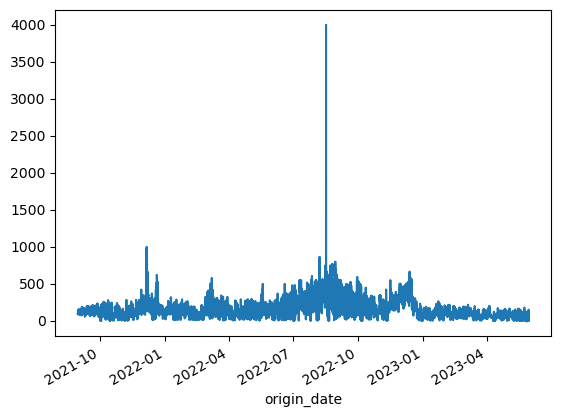

In [11]:
electricity_prices_df
electricity_prices_df["forecast_date"] = pd.to_datetime(electricity_prices_df["forecast_date"])
electricity_prices_df["origin_date"] = pd.to_datetime(electricity_prices_df["origin_date"]) 
electricity_prices_df.set_index("origin_date",inplace=True)

electricity_prices_df["euros_per_mwh"].plot()

## Training ETS models for electricity price prediction 

In [12]:
train_data,test_data = ts_split(electricity_prices_df,test_pct=0.2,freq = 'W')
pts_to_pred = len(test_data)

# Simple Exponential Smoothing - No trend No seasonality
ses = SimpleExpSmoothing(train_data["euros_per_mwh"]).fit(smoothing_level=0.7,optimized=False)
ses_forecast = ses.forecast(pts_to_pred)

# Double Exponential Smoothing / Holts Exponential Smoothing - Trend but No seasonality
des = ExponentialSmoothing(train_data["euros_per_mwh"], trend="mul").fit()
des_forecast = des.forecast(pts_to_pred)

# Triple Exponential Smoothing - Winters Exponential Smoothing - Trend and Seasonality
tes = ExponentialSmoothing(train_data["euros_per_mwh"],trend="mul",seasonal="add",seasonal_periods=10).fit()
tes_forecast = tes.forecast(pts_to_pred)

/Users/atharvamhaskar/miniconda3/envs/deep-learning/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/atharvamhaskar/miniconda3/envs/deep-learning/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


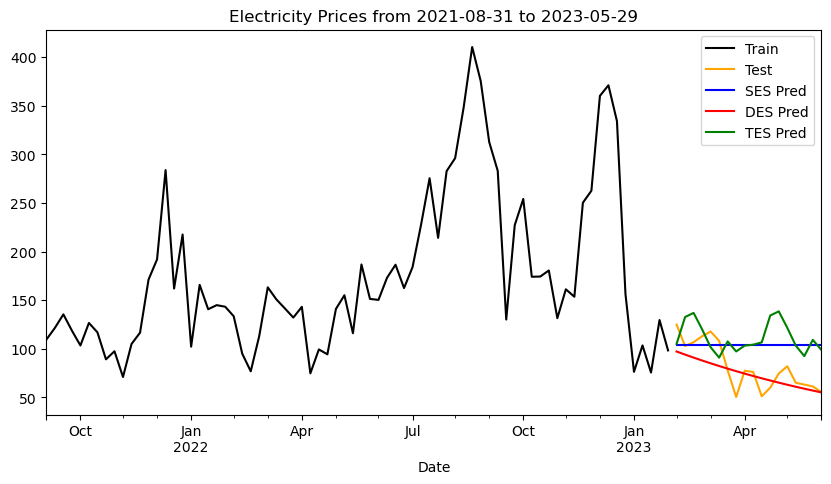

In [13]:
plt.figure(figsize=(10, 5))

train_data['euros_per_mwh'].plot(label='Train',color= "black")
test_data['euros_per_mwh'].plot(label='Test',color = "orange")

ses_forecast.plot(label="SES Pred",color = "blue")
des_forecast.plot(label="DES Pred",color = "red")
tes_forecast.plot(label="TES Pred",color = "green")


plt.title('Electricity Prices from {} to {}'.format(str(electricity_prices_df.index[0]).split()[0], str(electricity_prices_df.index[-1]).split()[0]))
plt.xlabel('Date')
plt.legend()

In [14]:
error_ses = test_data.values - ses_forecast.values.reshape(pts_to_pred,1)
error_des = test_data.values - des_forecast.values.reshape(pts_to_pred,1)
error_tes = test_data.values - tes_forecast.values.reshape(pts_to_pred,1)

In [15]:
print("Error Values for SES Model is:")
print(errors(test_data["euros_per_mwh"],ses_forecast.values))

print("\nError Values for DES Model is:")
print(errors(test_data["euros_per_mwh"],des_forecast.values))

print("\nError Values for TES Model is:")
print(errors(test_data["euros_per_mwh"],tes_forecast.values))

Error Values for SES Model is:

    Mean Squared Error: 32.462
    Mean Absolute Error: 27.923
    Mean Absolute Percentage Error: 0.431
    Weighted Mean Squared Error: 17.121
    Mean Forecast Error: -22.147
    

Error Values for DES Model is:

    Mean Squared Error: 16.817
    Mean Absolute Error: 13.255
    Mean Absolute Percentage Error: 0.160
    Weighted Mean Squared Error: 23.654
    Mean Forecast Error: 7.227
    

Error Values for TES Model is:

    Mean Squared Error: 39.491
    Mean Absolute Error: 35.713
    Mean Absolute Percentage Error: 0.521
    Weighted Mean Squared Error: 23.293
    Mean Forecast Error: -29.791
    


In [16]:
electricity_prices_final = des_forecast.values

## Training models to forecast electricity consumed

No. of training examples: 74
No. of testing examples: 18


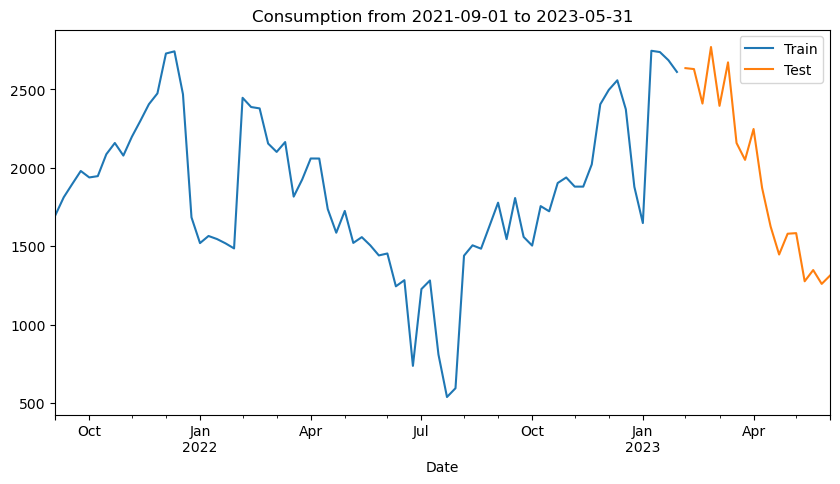

In [17]:
select_county = 5

temp = train_df.copy()
temp["datetime"] = pd.to_datetime(temp["datetime"])
consumption_df = temp[temp["is_consumption"] == 1]
consumption_df.set_index("datetime",inplace=True)
consumption_df = consumption_df.groupby(by = [consumption_df.index,"county"]).sum()
consumption_df.reset_index(inplace=True)
consumption_df.set_index("datetime",inplace=True)
consumption_df = consumption_df[consumption_df["county"] == select_county]

consumption_df.head()


train_data, test_data = ts_split(consumption_df,test_pct=0.2,freq='W')
pts_to_pred = len(test_data)

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")


plt.figure(figsize=(10, 5))
train_data['target'].plot(label='Train')
test_data['target'].plot(label='Test')
plt.title('Consumption from {} to {}'.format(str(consumption_df.index[0]).split()[0], str(consumption_df.index[-1]).split()[0]))
plt.xlabel('Date')
plt.legend()

In [18]:
# Simple Exponential Smoothing - No trend No seasonality
ses = SimpleExpSmoothing(train_data["target"]).fit(smoothing_level=0.7,optimized=False)
ses_forecast = ses.forecast(pts_to_pred)

# Double Exponential Smoothing / Holts Exponential Smoothing - Trend but No seasonality
des = ExponentialSmoothing(train_data["target"], trend="mul").fit()
des_forecast = des.forecast(pts_to_pred)

# Triple Exponential Smoothing - Winters Exponential Smoothing - Trend and Seasonality
tes = ExponentialSmoothing(train_data["target"],trend="mul",seasonal="add",seasonal_periods=12).fit()
tes_forecast = tes.forecast(pts_to_pred)

/Users/atharvamhaskar/miniconda3/envs/deep-learning/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


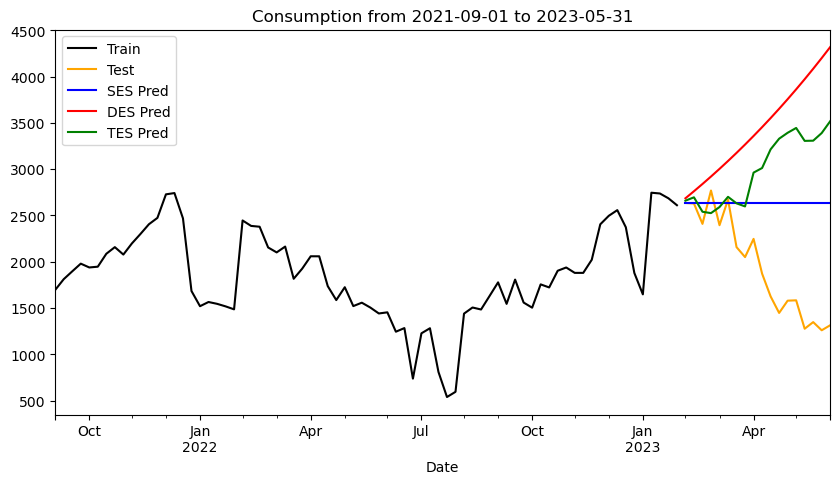

In [19]:
plt.figure(figsize=(10, 5))

# TRAIN
train_data['target'].plot(label='Train',color= "black")
# TEST
test_data['target'].plot(label='Test',color = "orange")

# SES
# ses.fittedvalues.plot(label = "SES Train",color="blue")
ses_forecast.plot(label="SES Pred",color = "blue")

# DES / HES
# des.fittedvalues.plot(label = "DES Train",color="yellow")
des_forecast.plot(label="DES Pred",color = "red")

# TES / WES
# tes.fittedvalues.plot(label = "TES Train",color="green")
tes_forecast.plot(label="TES Pred",color = "green")


plt.title('Consumption from {} to {}'.format(str(consumption_df.index[0]).split()[0], str(consumption_df.index[-1]).split()[0]))
plt.xlabel('Date')
plt.legend()

In [20]:
error_ses = test_data.values - ses_forecast.values.reshape(pts_to_pred,1)
error_des = test_data.values - des_forecast.values.reshape(pts_to_pred,1)
error_tes = test_data.values - tes_forecast.values.reshape(pts_to_pred,1)

In [21]:
print("Error Values for SES Model is:")
print(errors(test_data["target"],ses_forecast.values))

print("\nError Values for DES Model is:")
print(errors(test_data["target"],des_forecast.values))

print("\nError Values for TES Model is:")
print(errors(test_data["target"],tes_forecast.values))

Error Values for SES Model is:

    Mean Squared Error: 853.383
    Mean Absolute Error: 691.540
    Mean Absolute Percentage Error: 0.456
    Weighted Mean Squared Error: 78.291
    Mean Forecast Error: -670.895
    

Error Values for DES Model is:

    Mean Squared Error: 1795.052
    Mean Absolute Error: 1482.834
    Mean Absolute Percentage Error: 0.968
    Weighted Mean Squared Error: 174.576
    Mean Forecast Error: -1482.834
    

Error Values for TES Model is:

    Mean Squared Error: 1346.899
    Mean Absolute Error: 1058.027
    Mean Absolute Percentage Error: 0.706
    Weighted Mean Squared Error: 78.010
    Mean Forecast Error: -1030.877
    


In [22]:
consumption_final = ses_forecast.values

## Training models to forecast electricity produced

In [23]:
select_county = 1

temp = train_df.copy()
temp["datetime"] = pd.to_datetime(temp["datetime"])
production_df = temp[temp["is_consumption"] == 0]
production_df.set_index("datetime",inplace=True)
production_df = production_df.groupby(by = [production_df.index,"county"]).sum()
production_df.reset_index(inplace=True)
production_df.set_index("datetime",inplace=True)
production_df = production_df[production_df["county"] == select_county]

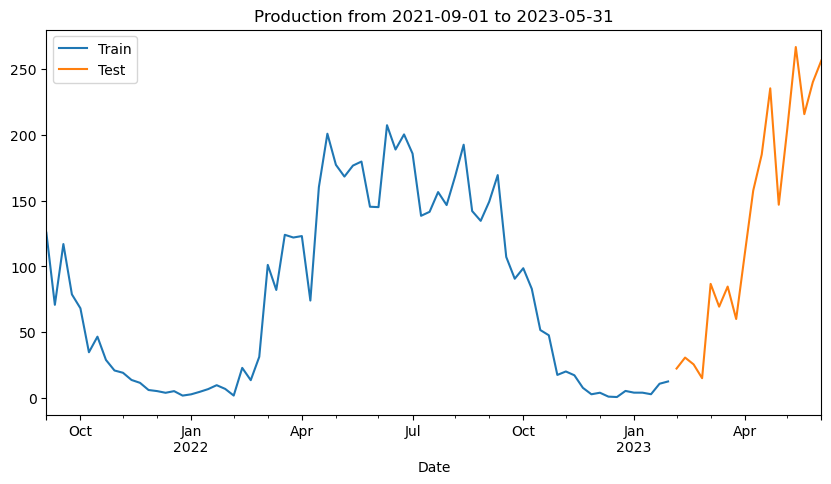

In [24]:
train_data, test_data = ts_split(production_df,test_pct=0.2,freq='W')
pts_to_pred = len(test_data)
title = 'Production from {} to {}'.format(str(production_df.index[0]).split()[0], str(production_df.index[-1]).split()[0])

pretraining_plot(train_data,test_data,"target",title)

In [25]:
train_funcs = [ets_models,arima_models,ltsf_models,randomforestregressors,xgboostregressors,fbprophet]
best_model = None
min_error = np.inf
error_dict = {}
prediction_data = test_data
prediction_colname = "target"

for func in train_funcs:
    cur_model = BestModelWrapper(func(train_data,test_data,"target",len(test_data)))
    labels = test_data["target"]
    predictions = cur_model.forecast(pts_to_pred)
    error_dict[cur_model.model_type]= compare_errors(labels,predictions)
    cur_error = get_error(labels,predictions) 
    if cur_error < min_error:
        best_model = cur_model
        min_error = cur_error

/Users/atharvamhaskar/miniconda3/envs/deep-learning/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/atharvamhaskar/miniconda3/envs/deep-learning/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/atharvamhaskar/miniconda3/envs/deep-learning/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/atharvamhaskar/miniconda3/envs/deep-learning/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/atharvamhaskar/miniconda3/envs/deep-learning/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountere


    Mean Squared Error: 45.117
    Mean Absolute Error: 35.061
    Mean Absolute Percentage Error: 0.280
    Weighted Mean Squared Error: 8.677
    Mean Forecast Error: 32.619
    


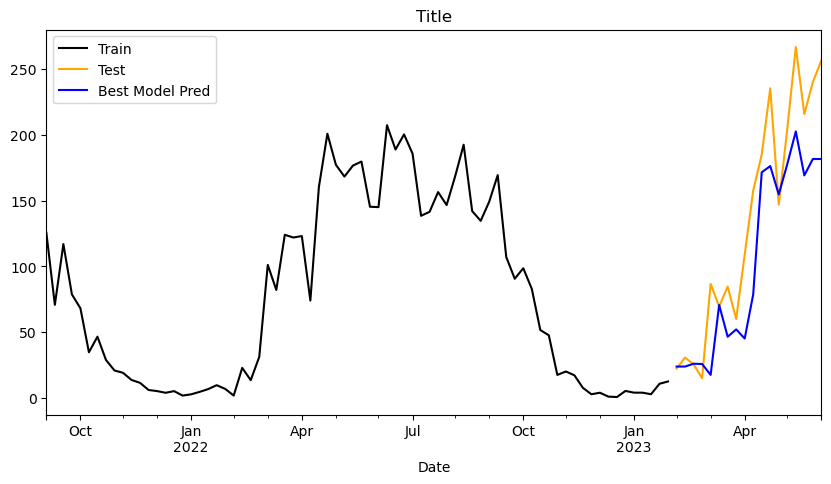

In [26]:
production_final = best_model.forecast(len(test_data))
posttraining_plot(train_data,test_data,"target",best_model)

In [27]:
error_table(error_dict)

,Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Mean Forecast Error
ETS,86.536464,78.170796,1.429371,8.398217
ARIMA,130.960961,106.283745,0.692664,106.128848
LTSFLinearForecaster,61.821279,47.681488,0.781542,12.522888
Random Forest Regressor,46.842631,38.411832,0.370909,28.622187
XG Boost Regressor,45.116652,35.060880,0.279943,32.619249
FB Prophet,47.116888,38.551294,0.407988,12.651235


## Displaying the amount of money saved by user

In [28]:
savings = savings_calculation(production_final,consumption_final,electricity_prices_final)

In [29]:
print("Based on our forecasted values the user would have saved: {:.2f}$ over {} weeks.".format(savings,len(test_data)))

Based on our forecasted values the user would have saved: 1208.10$ over 18 weeks.
